# Disease Type Classifier Evaluation

- BME 230A class project winter 2019
- Andrew E. Davidson
- [aedavids@ucsc.edu](mailto:aedavids@edu?subject=SimpleModel.ipynb)

ref: diseaseTypeClassifier.ipynb

identify genes that maximal activate and compare to known cancer causing genes

In [1]:
from keras.models import load_model

import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd

from sklearn.preprocessing import LabelEncoder
import sys

import tensorflow as tf

# fix random seed for reproducibility
theMeaningOfLife = 42

import keras
if "2.1.6" != keras.__version__ :
    emsg = "ERROR keras version {} != 2.1.6, new version can not save and restore models".format(keras.__version__)
    raise ValueError(emsg)

# add path to our local modules
# assume they are in the same directory we launched the juypter server in
# /home/ubuntu/BME-230a
!pwd
localModuleDir = "."
sys.path.append(localModuleDir)

Using TensorFlow backend.


/home/ubuntu/BME-230a


## load model and data

In [2]:
%%time
rootDir = "/bme-230a-ebs"
sourceDataFilePath = "{}/data/tcga_target_gtex.h5".format(rootDir)
print(sourceDataFilePath)
if not os.path.isfile(sourceDataFilePath) :
    emsg = "ERROR: {} not found".format(sourceDataFilePath)
    print(emsg)
    print("change rootDir")
    sys.stdout.flush() # force error message to print
    raise ValueError(emsg)
    
from loadData import loadCancerDiseaseTypeTidyDataSet

ret = loadCancerDiseaseTypeTidyDataSet(rootDir)
diseaseLabelEncoder, XTrainNumpy, yTrainNumpy, XTestNumpy, yTestNumpy = ret
#XTestNumpy = yTestNumpy = None # clean up memory
ret = None # clean up memory

/bme-230a-ebs/data/tcga_target_gtex.h5
sourceDataFilePath:/bme-230a-ebs/data/tcga_target_gtex.h5
CPU times: user 1.33 s, sys: 4.96 s, total: 6.29 s
Wall time: 6.29 s


## <span style="color:red"> AEDWIP the data looks suprisingly clean</span>
- was there a bug in the original data set prepration ?
- was a bug introduced while creating the tidy data set?
    * maybe sklearn.model_selection.StratifiedShuffleSplit samples with replacement by default?
- signifigant figure?

In [3]:
print(XTrainNumpy[0:10, 0:3])

[[-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]]


In [4]:
# print(yTrainNumpy[0:3,:]) shape (1, 1 + k ) [0] is diseasy type, rest is one hot
# looks like maybe a bug
# load XDF and YDF , what is the deiase value if normal? I get it imputed to either NaN or 0

In [5]:
modelName="diseaseClassifier"
modelRootDir = "{}/models".format(rootDir)
fullModelPath = "{}/{}.h5".format(modelRootDir, modelName)
diseaseClassifierModel = load_model(fullModelPath)
diseaseClassifierModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 58581)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 58581)             234324    
_________________________________________________________________
dense_1 (Dense)              (None, 38)                2226116   
_________________________________________________________________
activation_1 (Activation)    (None, 38)                0         
Total params: 2,460,440
Trainable params: 2,343,278
Non-trainable params: 117,162
_________________________________________________________________


In [6]:
%%time
# find which class a gene maximal activates
def findAEDWIP(model, m, batchSize):
    '''
    input:
        model:
        #n: the number of examples
        m: the number of features
        batchSize
    '''
    ret = np.zeros((m,1))
    numBatches,r = divmod(m, batchSize)
    print("m:{} batchSize:{} numBatches:{} r:{}".format(m, batchSize, numBatches, r))
    startRowIdx = 0
    batchCount = 0
    while (batchCount < numBatches):
        if batchCount < numBatches:
            bs = batchSize
        else:
            bs = r # short batch

        # create a feature vector one hot. We only want the activation f
        # value for a single gene
        batch = np.zeros((bs, m))
        for j in range(bs):
            # use a high value
            # when value was 1 all predictions where class 27
            batch[j, startRowIdx + j] = 1000000 
        
        predictions = model.predict(batch)
        predictedValuesTensor = keras.backend.argmax(predictions)

        # use keras escape hatch to tensor flow
        # there is probably a better way to do this
        sess = tf.Session()
        with sess.as_default():
            predictedValuesNumpy = predictedValuesTensor.eval()  

        shape = predictedValuesNumpy.shape
        ret[startRowIdx: startRowIdx+bs] = np.reshape(predictedValuesNumpy, (shape[0],-1))
        
        # increment loop counts
        batchCount += 1
        startRowIdx += bs
        #print("batchCount:{} next start:{}".format( batchCount,startRowIdx))

    return ret
    

# why hold on to all the memory we can probably pick these values out of the mode
xShape= XTrainNumpy.shape
maxActivations = findAEDWIP(diseaseClassifierModel, m=xShape[1],  batchSize=6000) 
print("maxActivations.shape:{}".format(maxActivations.shape))

m:58581 batchSize:6000 numBatches:9 r:4581
maxActivations.shape:(58581, 1)
CPU times: user 1min 22s, sys: 12.6 s, total: 1min 34s
Wall time: 27.2 s


In [7]:
print(np.transpose(maxActivations[100:300]))

[[ 6. 26.  6. 30.  0. 14.  6.  6.  6. 33.  6. 29.  5. 14. 19. 20.  6. 16.
  16. 16.  6.  6. 33. 26.  6. 30. 29. 27. 26. 26. 16. 16. 26.  4. 29. 26.
   5. 23. 29. 16. 26.  6.  5. 26. 26.  6. 19.  5. 16. 23. 20. 26. 16.  6.
  26.  6. 20. 14.  6. 14. 29. 26. 20.  6. 23.  4. 29. 12. 19. 23. 30. 16.
  26.  6.  6. 26. 33. 16. 16. 26. 10. 19. 16. 29. 29. 23. 16. 26. 16. 26.
  29. 29. 16.  6.  6. 26. 20. 23. 10. 16. 30.  6.  6. 16. 16. 23.  6.  6.
   6. 16.  6. 23. 29. 26. 30.  6. 33. 20.  6. 23.  6. 29.  6. 29. 29. 16.
  23.  6.  6. 23.  6.  6.  1. 23. 16. 20.  1.  6. 16. 16. 23. 19.  5.  6.
  17. 29.  6.  6. 30. 16. 16.  6.  6. 23. 16. 29.  6. 26. 23. 20. 14. 29.
  20. 33. 16. 16.  6. 29. 26. 16.  5. 16. 12. 19. 16.  6. 16. 23. 23.  5.
  23. 30. 23. 20.  5. 26. 23.  6. 14. 14. 16.  6. 26. 16. 16. 26. 23.  6.
  20. 23.]]


In [8]:
# geneIdx is the feature column index
# print(xShape[1])
# geneIdx = np.arange(xShape[1]) 
# print(geneIdx.shape)
# print(geneIdx)

xxxDF = pd.DataFrame(maxActivations, columns=["diseaseValue"])
print(xxxDF.head())
print(xxxDF.tail())
print(xxxDF.index)
print(xxxDF.shape)

   diseaseValue
0          23.0
1          16.0
2           6.0
3          20.0
4           6.0
       diseaseValue
58576           0.0
58577           0.0
58578           0.0
58579           0.0
58580           0.0
RangeIndex(start=0, stop=58581, step=1)
(58581, 1)


In [9]:
%%capture --no-display
# turn off deprecation warnings
# https://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=capture#cellmagic-capture
counts = dict()
grouped = xxxDF.groupby("diseaseValue")
for diseaseValue, group in grouped:
    stats = group.agg(['count'])
    dv = int(diseaseValue)
    key = "{}_{}".format(dv,diseaseLabelEncoder.inverse_transform([dv]) )
    counts[key] = stats.values

In [10]:
print("key:24_['Pancreatic Adenocarcinoma'] maximal activated gene count:{}"
         .format(counts["24_['Pancreatic Adenocarcinoma']"]))

key:24_['Pancreatic Adenocarcinoma'] maximal activated gene count:[[44]]


In [11]:
# plt.hist(countsList,  bins=38, label=list(counts.keys()) )

In [12]:
# dt = diseaseLabelEncoder.inverse_transform(range(38))
# fig, ax = plt.subplots()
# fig.set_size_inches(20,5)
# plt.bar(dt, countsList )
# # plt.bar(countsList, dt )

# # https://stackoverflow.com/a/52724092/4586180
# # Rotation of the bars names
# plt.xticks(rotation=45)
# plt.show()

In [13]:
%%capture --no-display
# turn off deprecation warnings
# https://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=capture#cellmagic-capture
dt = diseaseLabelEncoder.inverse_transform(range(38))

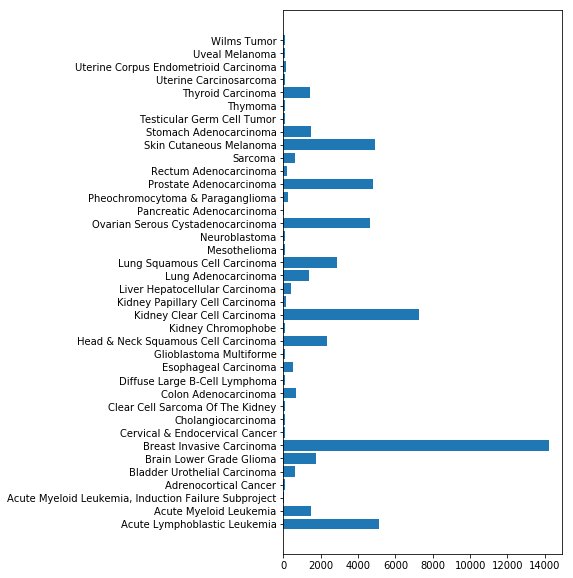

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(5,10)
countsList = [v[0][0] for v in counts.values()]
plt.barh(dt, countsList )
plt.show()